# Imports

In [51]:
from PIL import Image, ImageOps, ImageDraw, ImageEnhance
from bresenham import bresenham
from skimage.color import rgb2gray
from skimage.draw import line
import numpy as np
import matplotlib.pyplot as plt
import sys
import cv2
import dlib



# Parameters

In [52]:
# Parameters 
INPUT_IMAGE_PATH = "simple-drawing.png"
OUTPUT_IMAGE_PATH = "simple-drawing_threaded.png"
OUTPUT_IMAGE_DIMENSIONS = (600, 600)
OUTPUT_IMAGE_RADIUS = OUTPUT_IMAGE_DIMENSIONS[0] / 2 - 0.5 # -0.5 to make it exactly on the center
OUTPUT_IMAGE_CENTER_POSITION = (OUTPUT_IMAGE_DIMENSIONS[0] / 2, OUTPUT_IMAGE_DIMENSIONS[1] / 2)
NAILS_AMOUNT = 200
SKIP_NEIGHBOUR_NAILS = 30
ITERATIONS = 2000

MASK_BACKGROUND_COLOR = 10
MASK_FACE_COLOR = 100
MASK_FEATURES_GRADIENT = (200, 100)


INPUT_IMAGE_PATH = "taco.png"
OUTPUT_IMAGE_PATH = "taco_threaded.png"


print("Parameters:")
print("INPUT_IMAGE_PATH: " + INPUT_IMAGE_PATH)
print("OUTPUT_IMAGE_PATH: " + OUTPUT_IMAGE_PATH)
print("OUTPUT_IMAGE_DIMENSIONS: " + str(OUTPUT_IMAGE_DIMENSIONS))
print("OUTPUT_IMAGE_RADIUS: " + str(OUTPUT_IMAGE_RADIUS))
print("OUTPUT_IMAGE_CENTER_POSITION: " + str(OUTPUT_IMAGE_CENTER_POSITION))
print("NAILS_AMOUNT: " + str(NAILS_AMOUNT))
print("SKIP_NEIGHBOUR_NAILS: " + str(SKIP_NEIGHBOUR_NAILS))

Parameters:
INPUT_IMAGE_PATH: taco.png
OUTPUT_IMAGE_PATH: taco_threaded.png
OUTPUT_IMAGE_DIMENSIONS: (600, 600)
OUTPUT_IMAGE_RADIUS: 299.5
OUTPUT_IMAGE_CENTER_POSITION: (300.0, 300.0)
NAILS_AMOUNT: 200
SKIP_NEIGHBOUR_NAILS: 30


20


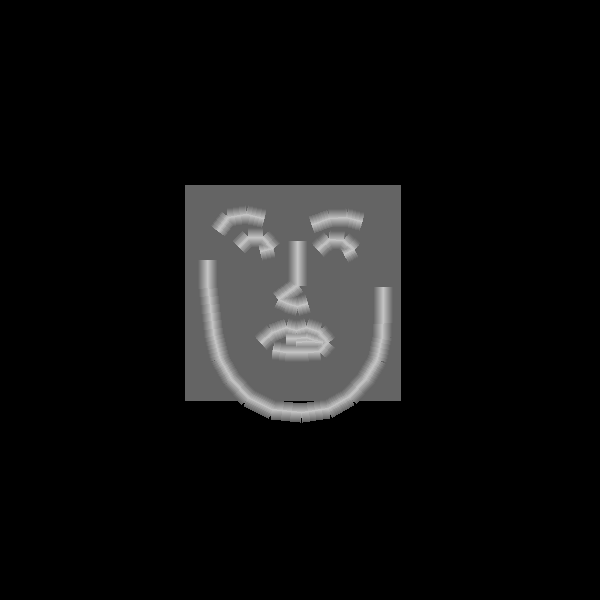

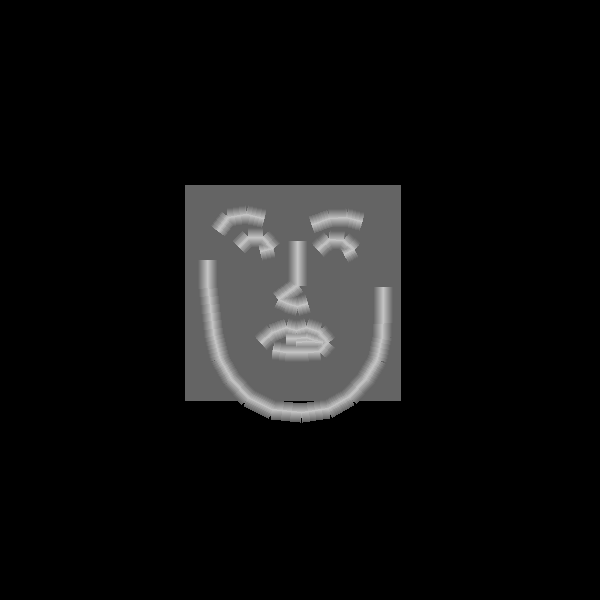

In [61]:

# Display a list of points on a given image
def display_points(points, image):
    canvas = image.copy()
    for point in points:
        canvas.putpixel((int(point[0]), int(point[1])), 0)
    display(canvas)
    


def get_input_image():
    # Load image as grayscale
    image = Image.open(INPUT_IMAGE_PATH).convert('LA')
    
    # Crop image to a square
    width, height = image.size
    if width > height:
        left = (width - height) / 2
        right = left + height
        top = 0
        bottom = height
    else:
        left = 0
        right = width
        top = (height - width) / 2
        bottom = top + width
    image.crop((left, top, right, bottom))

    # Resize image
    image = image.resize(OUTPUT_IMAGE_DIMENSIONS)

    # Crop image to a circle
    mask = Image.new('L', image.size, 0)
    draw = ImageDraw.Draw(mask) 
    draw.ellipse((0, 0) + image.size, fill=255)
    output = ImageOps.fit(image, mask.size, centering=(0.5, 0.5))
    output.putalpha(mask)

    # Replace alpha pixels with (0, 0) (might be unnecessary)
    temp = []
    for pixel in output.getdata():
        if pixel[1] == 0:
            temp.append((0, 0))
        else:
            temp.append(pixel)
    final_image = output.copy()
    final_image.putdata(temp)

    final_image = ImageEnhance.Contrast(final_image).enhance(1)

    
    return final_image

img = get_input_image()
# print(img.size)
# display(img)


# Convert CV2 image to PIL image
def cv2pil(cv2_img):
    return Image.fromarray(cv2_img)

# Convert PIL image to CV2 image
def pil2cv2(pil_img):
    return np.array(pil_img)


def get_input_image_mask(input_image):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    input_image_cv2 = np.array(input_image.convert('L'))

    faces = detector(input_image_cv2)
    if len(faces) > 1:
        print("More than one face detected")
        return None
    elif len(faces) == 0:
        print("No faces detected")
        return None
    
    x1 = faces[0].left() 
    y1 = faces[0].top() 
    x2 = faces[0].right()
    y2 = faces[0].bottom() 

    # Create landmark object
    landmarks = predictor(image=input_image_cv2, box=faces[0])
    points = []
    # Loop through all the points
    for n in range(0, 68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        points.append((x, y))

    # Empty image
    mask = Image.new('L', input_image.size, MASK_BACKGROUND_COLOR)
    draw = ImageDraw.Draw(mask)

    # Jaw Points = 0–16
    # Right Brow Points = 17–21
    # Left Brow Points = 22–26
    # Nose Points = 27–35
    # Right Eye Points = 36–41
    # Left Eye Points = 42–47
    # Mouth Points = 48–60
    # Lips Points = 61–67

    draw.rectangle((x1, y1, x2, y2), outline=MASK_FACE_COLOR, fill=MASK_FACE_COLOR)

    # Distance between points
    distance = int(np.sqrt((x1 - x2)**2 + (y1 - y2)**2) / 15)
    print(distance)

    for level in range(distance, 0, -1):
        st = int((level / distance) * (MASK_FEATURES_GRADIENT[1] - MASK_FEATURES_GRADIENT[0]) + MASK_FEATURES_GRADIENT[0])
        draw.line(points[0:16], fill=st, width=level) # Jaw
        draw.line(points[17:21], fill=st, width=level) # Right Brow
        draw.line(points[22:26], fill=st, width=level) # Left Brow
        draw.line(points[27:35], fill=st, width=level) # Nose
        draw.line(points[36:41], fill=st, width=level) # Right Eye
        draw.line(points[42:47], fill=st, width=level) # Left Eye
        draw.line(points[48:60], fill=st, width=level) # Mouth
        draw.line(points[61:67], fill=st, width=level) # Lips

    display(mask)

    return mask

    
get_input_image_mask(img)

# get_input_image_mask(img)


In [5]:


# Display a list of lines on a given image
def display_threads(lines, image):
    canvas = image.copy()
    for line in lines:
        draw = ImageDraw.Draw(canvas)
        draw.line((line[0][0], line[0][1], line[1][0], line[1][1]), fill=0, width=1)
    display(canvas)


# Display a list of points on a given image
def display_points(points, image):
    canvas = image.copy()
    for point in points:
        canvas.putpixel((int(point[0]), int(point[1])), 0)
    display(canvas)
    
    
    
    
    
    
def generate_new_image(dimensions):
    return Image.new('L', dimensions, 255)
    
def generate_nail_positions(radius, center, amount):
    nails = []
    for i in range(0, amount):
        angle = (2 * np.pi * i / amount) - np.pi / 2 # -pi/2 to make it start at the top
        x = radius * np.cos(angle) + center[0]
        y = radius * np.sin(angle) + center[1]
        nails.append((int(x), int(y)))
    return nails

def generate_thread_positions(nails):
    threads = []
    for i in range(0, len(nails)):
        for j in range(i + 1 + SKIP_NEIGHBOUR_NAILS, len(nails)):
            if i == 0 and j >= len(nails) - SKIP_NEIGHBOUR_NAILS: continue # Skip the last nails in first iteration
            threads.append((nails[i], nails[j]))
    return threads

def get_threads_from_nail(threads, nail):
    threads_from_nail = []
    for thread in threads:
        if nail in thread:
            threads_from_nail.append(thread)
    return threads_from_nail

def generate_nail_to_threads_dictionary(nails, threads):
    nail_to_thread_dictionary = {}
    for nail in nails:
        nail_to_thread_dictionary[nail] = get_threads_from_nail(threads, nail)
    return nail_to_thread_dictionary

def generate_thread_to_points_dictionary(threads):
    thread_to_points_dictionary = {}
    for thread in threads:
        a, b = line(thread[0][0], thread[0][1], thread[1][0], thread[1][1])
        points = []
        for i in range(len(a)):
            points.append((a[i], b[i]))
        thread_to_points_dictionary[thread] = points

    return thread_to_points_dictionary


# img = generate_new_image((28, 28))
# n = generate_nail_positions(13.5, (14, 14), 6)
# t = generate_thread_positions(n)
# ntt = generate_nail_to_threads_dictionary(n, t)
# ttp = generate_thread_to_points_dictionary(t)

# display(img)
# display_points(n, img)
# display_threads(t, img)

# test = img.copy()
# for x in ttp[t[3]]:
#     print(x)
#     test.putpixel(x, (255))
# display(test)



def get_other_end_of_thread(thread, nail):
    if nail == thread[0]:
        return thread[1]
    else:
        return thread[0]

# dictionary[thread] = ((all, coords), (of, the), (threads, that), (start, at), (nail, nail))


# Get all threads from a given nail



# def remove_hidden_values(image):
#     new_image = []
#     display(np.array(image))
#     for pixel in image.getdata():
#         if pixel[1] == 0:
#             new_image.append((0, 0))
#         else:
#             new_image.append(pixel)
#     g = image.copy()
#     g.putdata(new_image)
#     return g




# Draw white line on the image
def draw_line(image, line):
    draw = ImageDraw.Draw(image)
    draw.line((line[0][0], line[0][1], line[1][0], line[1][1]), fill=(255, 255), width=1)
    return image


def get_sum_of_values_of_no_alpha_pixels(image):
    sum = 0
    for pixel in image.getdata():
        if pixel[1] == 255:
            sum += pixel[0]
    return sum

def get_amount_of_no_alpha_pixels(image):
    sum = 0
    for pixel in image.getdata():
        if pixel[1] == 255:
            sum += 1
    return sum

def get_image_fitness(image):
    a = np.sum(image) / (np.pi * OUTPUT_IMAGE_RADIUS ** 2)
    return get_sum_of_values_of_no_alpha_pixels(image) / get_amount_of_no_alpha_pixels(image)

    test = Image.new('LA', (3, 3), (255, 0))
    test.putpixel((0, 0), (255, 255))
    test.putpixel((1, 0), (0, 0))
    test.putpixel((2, 0), (0, 255))
    test.putpixel((0, 1), (255, 0))
#     display(test)
#     display(np.array(test))
    
    sum = get_sum_of_values_of_no_alpha_pixels(test)
    amount = get_amount_of_no_alpha_pixels(test)
    

    display(test)
    display(np.array(test))

    display(sum)
    display(amount)
    display(sum / amount)
    # print(np.sum(np.array(image)))
    # print(np.sum(np.array(image.convert('L'))))
    # image_array = np.array(image.convert('L'))
    # display(image.convert('L'))
    # print(image_array)
    # np.sum(image_array)
    # print(np.sum(image_array))

# get_image_fitness(get_prepared_input_image())



# output_image = generate_new_image(OUTPUT_IMAGE_DIMENSIONS)
# n = generate_nail_positions(OUTPUT_IMAGE_RADIUS, OUTPUT_IMAGE_CENTER_POSITION, NAILS_AMOUNT)
#display(display_points(n, output_image))
# t = generate_thread_positions(n)


# g = get_threads_from_nail(t, n[0])



#display_lines(e, output_image)#.save('nails.png')

# Own algorithm

In [6]:


def get_thread_inaccuracy(thread, ttp, input_image):
    inaccuracy = 0
    # print("Thread: " + str(thread))
    for i in ttp[thread]:
        # print("Point: " + str(i), "value:", input_image.getpixel(i))
        inaccuracy += input_image.getpixel(i)[0]
    return inaccuracy / len(ttp[thread])
    
def get_best_fitting_thread(threads, ttp, input_image): # which thread cover the most black and the least white
    best_fitting_thread = None
    best_fitting_thread_inaccuracy = 10000000
    for thread in threads:
        inaccuracy = get_thread_inaccuracy(thread, ttp, input_image) 
        if inaccuracy < best_fitting_thread_inaccuracy:
            best_fitting_thread = thread
            best_fitting_thread_inaccuracy = inaccuracy
    return best_fitting_thread

Current nail # 0 :  (300, 0)


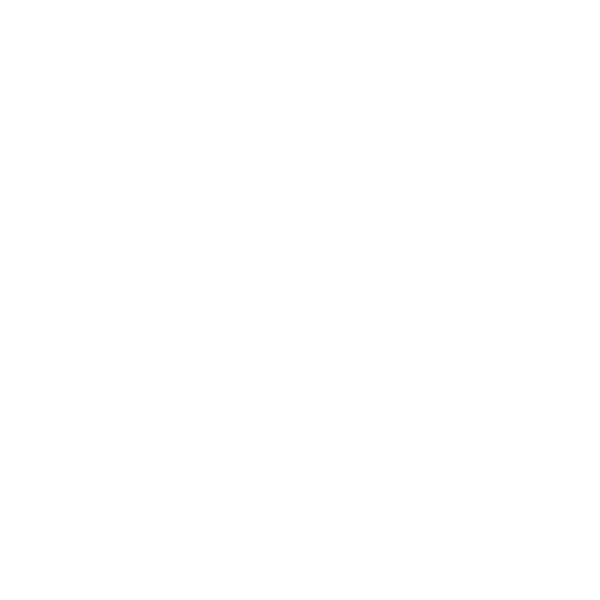

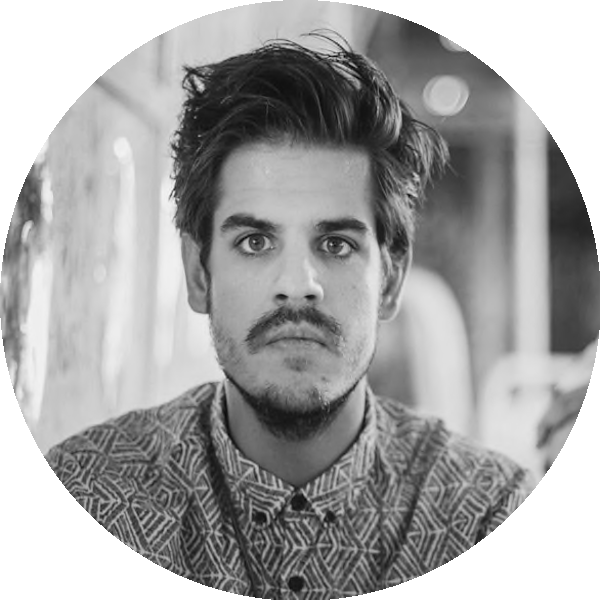

Current nail # 1 :  (597, 337)
Current nail # 2 :  (234, 7)
Current nail # 3 :  (598, 318)
Current nail # 4 :  (189, 21)
Current nail # 5 :  (598, 281)
Current nail # 6 :  (164, 33)
Current nail # 7 :  (594, 243)
Current nail # 8 :  (139, 47)
Current nail # 9 :  (595, 253)
Current nail # 10 :  (164, 33)
Current nail # 11 :  (592, 234)
Current nail # 12 :  (189, 21)
Current nail # 13 :  (243, 594)
Current nail # 14 :  (511, 511)
Current nail # 15 :  (101, 524)
Current nail # 16 :  (383, 587)
Current nail # 17 :  (52, 468)
Current nail # 18 :  (435, 566)
Current nail # 19 :  (155, 562)
Current nail # 20 :  (483, 536)
Current nail # 21 :  (52, 468)
Current nail # 22 :  (309, 599)
Current nail # 23 :  (198, 18)
Current nail # 24 :  (581, 198)
Current nail # 25 :  (94, 81)
Current nail # 26 :  (570, 172)
Current nail # 27 :  (547, 468)
Current nail # 28 :  (562, 155)
Current nail # 29 :  (123, 57)
Current nail # 30 :  (595, 253)
Current nail # 31 :  (427, 29)
Current nail # 32 :  (225, 590)

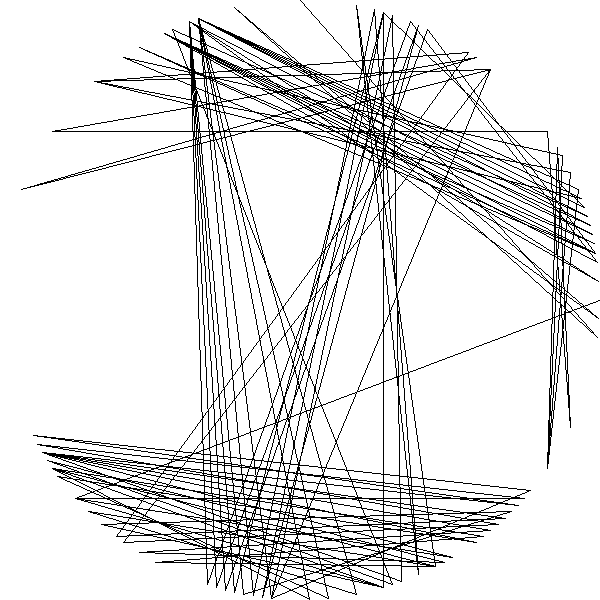

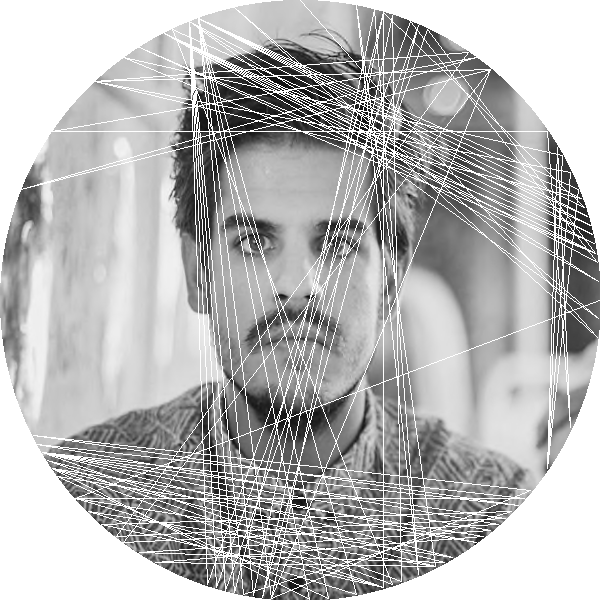

Current nail # 101 :  (147, 42)
Current nail # 102 :  (598, 281)
Current nail # 103 :  (418, 25)
Current nail # 104 :  (9, 225)
Current nail # 105 :  (468, 52)
Current nail # 106 :  (25, 181)
Current nail # 107 :  (452, 42)
Current nail # 108 :  (164, 566)
Current nail # 109 :  (468, 547)
Current nail # 110 :  (69, 490)
Current nail # 111 :  (392, 584)
Current nail # 112 :  (401, 18)
Current nail # 113 :  (198, 581)
Current nail # 114 :  (189, 21)
Current nail # 115 :  (253, 595)
Current nail # 116 :  (483, 63)
Current nail # 117 :  (101, 524)
Current nail # 118 :  (547, 468)
Current nail # 119 :  (33, 435)
Current nail # 120 :  (536, 483)
Current nail # 121 :  (25, 418)
Current nail # 122 :  (547, 468)
Current nail # 123 :  (574, 181)
Current nail # 124 :  (198, 18)
Current nail # 125 :  (300, 599)
Current nail # 126 :  (490, 69)
Current nail # 127 :  (243, 594)
Current nail # 128 :  (435, 33)
Current nail # 129 :  (29, 172)
Current nail # 130 :  (444, 37)
Current nail # 131 :  (12, 2

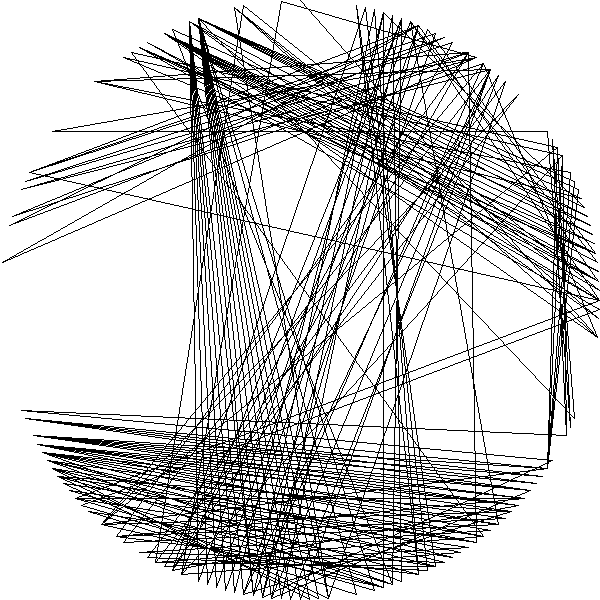

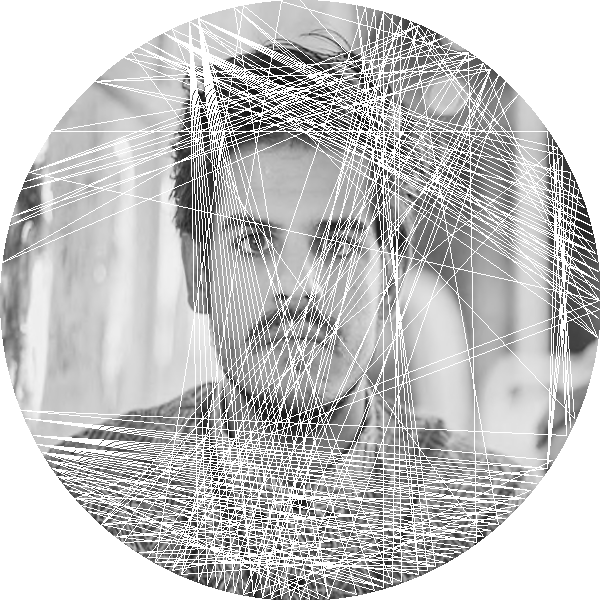

Current nail # 201 :  (281, 1)
Current nail # 202 :  (594, 243)
Current nail # 203 :  (189, 21)
Current nail # 204 :  (189, 578)
Current nail # 205 :  (511, 511)
Current nail # 206 :  (216, 587)
Current nail # 207 :  (518, 94)
Current nail # 208 :  (81, 505)
Current nail # 209 :  (346, 595)
Current nail # 210 :  (198, 18)
Current nail # 211 :  (243, 594)
Current nail # 212 :  (401, 18)
Current nail # 213 :  (595, 346)
Current nail # 214 :  (198, 18)
Current nail # 215 :  (337, 597)
Current nail # 216 :  (511, 88)
Current nail # 217 :  (198, 581)
Current nail # 218 :  (290, 0)
Current nail # 219 :  (365, 592)
Current nail # 220 :  (198, 18)
Current nail # 221 :  (599, 309)
Current nail # 222 :  (63, 483)
Current nail # 223 :  (401, 581)
Current nail # 224 :  (198, 18)
Current nail # 225 :  (225, 590)
Current nail # 226 :  (530, 109)
Current nail # 227 :  (584, 392)
Current nail # 228 :  (225, 9)
Current nail # 229 :  (592, 234)
Current nail # 230 :  (392, 15)
Current nail # 231 :  (1, 3

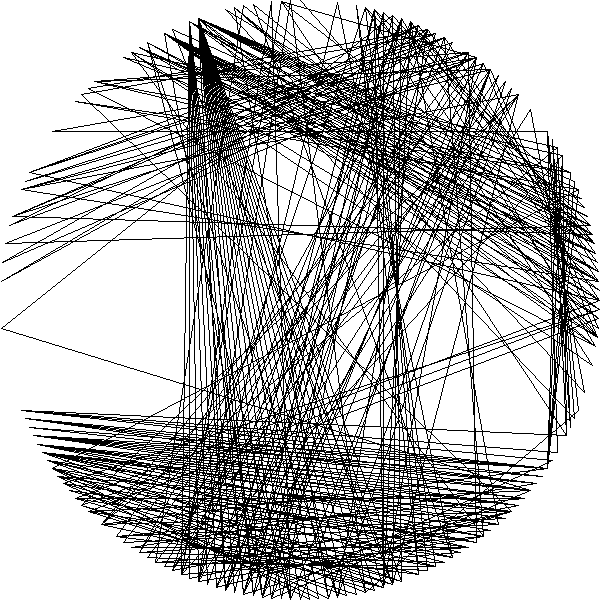

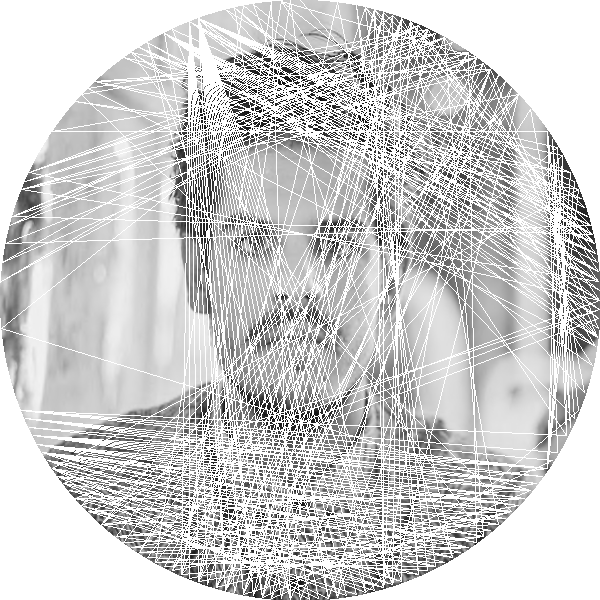

Current nail # 301 :  (418, 574)
Current nail # 302 :  (42, 452)
Current nail # 303 :  (435, 566)
Current nail # 304 :  (131, 547)
Current nail # 305 :  (547, 131)
Current nail # 306 :  (109, 530)
Current nail # 307 :  (518, 505)
Current nail # 308 :  (101, 75)
Current nail # 309 :  (498, 524)
Current nail # 310 :  (207, 584)
Current nail # 311 :  (392, 15)
Current nail # 312 :  (598, 318)
Current nail # 313 :  (243, 594)
Current nail # 314 :  (365, 7)
Current nail # 315 :  (524, 498)
Current nail # 316 :  (29, 427)
Current nail # 317 :  (542, 476)
Current nail # 318 :  (2, 337)
Current nail # 319 :  (101, 75)
Current nail # 320 :  (505, 518)
Current nail # 321 :  (37, 444)
Current nail # 322 :  (597, 337)
Current nail # 323 :  (207, 15)
Current nail # 324 :  (566, 164)
Current nail # 325 :  (547, 468)
Current nail # 326 :  (552, 139)
Current nail # 327 :  (75, 498)
Current nail # 328 :  (337, 597)
Current nail # 329 :  (123, 57)
Current nail # 330 :  (599, 290)
Current nail # 331 :  (

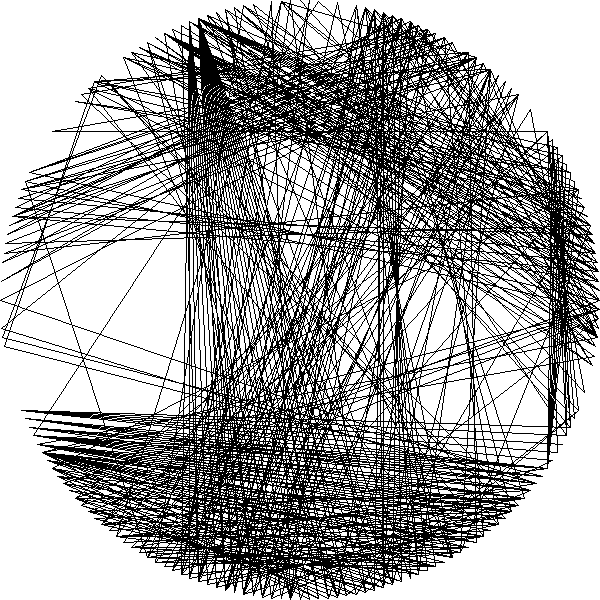

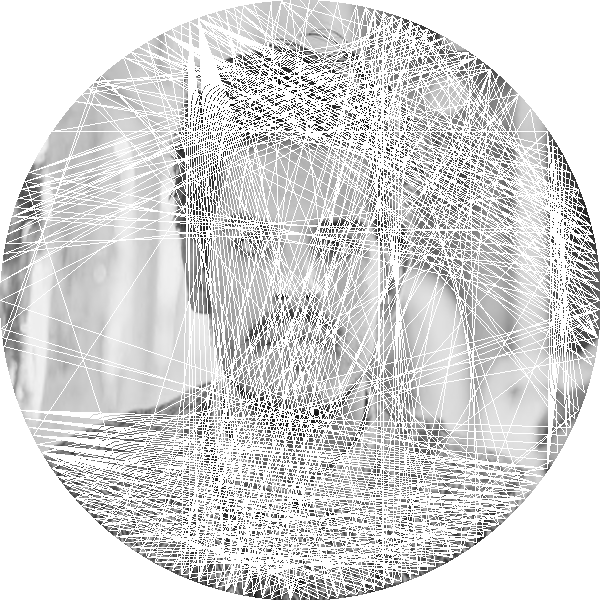

Current nail # 401 :  (566, 164)
Current nail # 402 :  (0, 300)
Current nail # 403 :  (452, 42)
Current nail # 404 :  (94, 81)
Current nail # 405 :  (505, 518)
Current nail # 406 :  (505, 81)
Current nail # 407 :  (88, 511)
Current nail # 408 :  (392, 584)
Current nail # 409 :  (123, 57)
Current nail # 410 :  (309, 599)
Current nail # 411 :  (468, 52)
Current nail # 412 :  (599, 309)
Current nail # 413 :  (401, 18)
Current nail # 414 :  (511, 511)
Current nail # 415 :  (511, 88)
Current nail # 416 :  (281, 1)
Current nail # 417 :  (109, 530)
Current nail # 418 :  (524, 101)
Current nail # 419 :  (271, 598)
Current nail # 420 :  (547, 468)
Current nail # 421 :  (37, 444)
Current nail # 422 :  (536, 483)
Current nail # 423 :  (584, 207)
Current nail # 424 :  (328, 1)
Current nail # 425 :  (444, 562)
Current nail # 426 :  (81, 505)
Current nail # 427 :  (498, 75)
Current nail # 428 :  (253, 595)
Current nail # 429 :  (318, 1)
Current nail # 430 :  (328, 598)
Current nail # 431 :  (587, 21

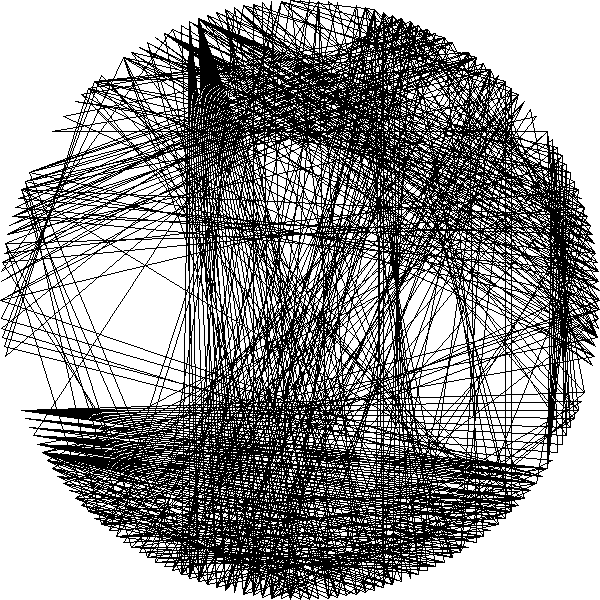

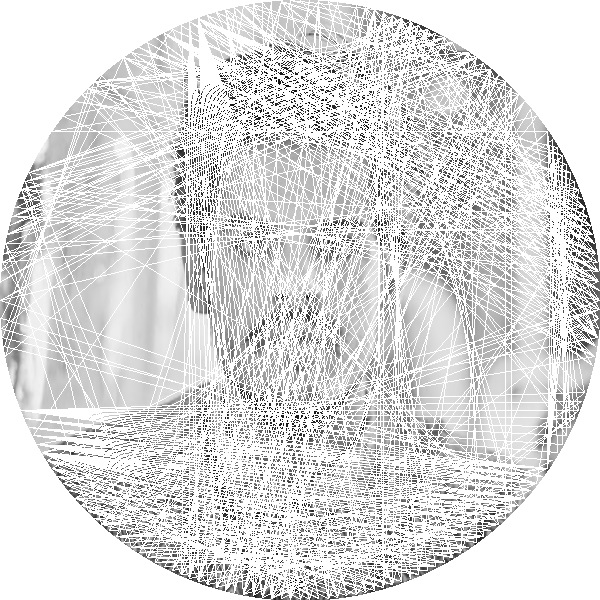

Current nail # 501 :  (116, 63)
Current nail # 502 :  (383, 587)
Current nail # 503 :  (590, 374)
Current nail # 504 :  (253, 4)
Current nail # 505 :  (216, 587)
Current nail # 506 :  (181, 25)
Current nail # 507 :  (328, 598)
Current nail # 508 :  (29, 427)
Current nail # 509 :  (530, 490)
Current nail # 510 :  (5, 356)
Current nail # 511 :  (552, 460)
Current nail # 512 :  (290, 0)
Current nail # 513 :  (599, 290)
Current nail # 514 :  (460, 47)
Current nail # 515 :  (123, 542)
Current nail # 516 :  (476, 542)
Current nail # 517 :  (452, 42)
Current nail # 518 :  (47, 139)
Current nail # 519 :  (552, 139)
Current nail # 520 :  (309, 599)
Current nail # 521 :  (552, 460)
Current nail # 522 :  (25, 418)
Current nail # 523 :  (524, 498)
Current nail # 524 :  (590, 225)
Current nail # 525 :  (262, 597)
Current nail # 526 :  (18, 198)
Current nail # 527 :  (599, 290)
Current nail # 528 :  (0, 309)
Current nail # 529 :  (483, 63)
Current nail # 530 :  (290, 599)
Current nail # 531 :  (42, 

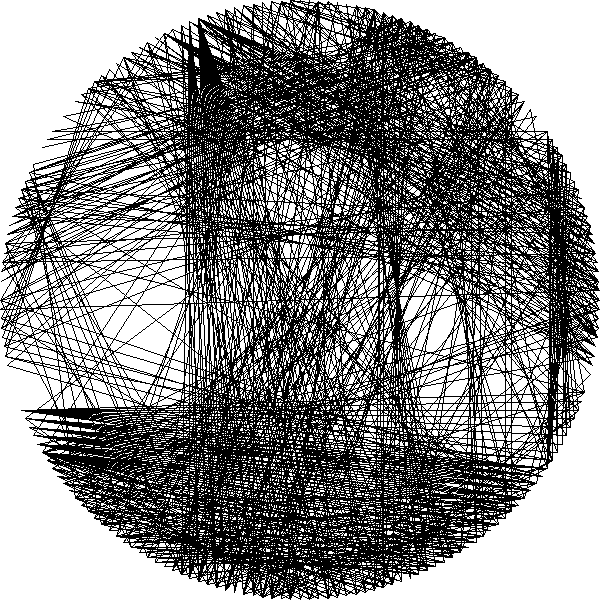

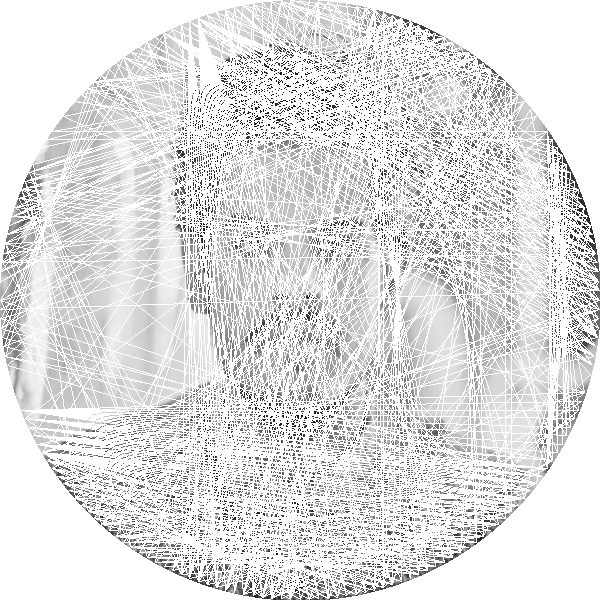

Current nail # 601 :  (597, 337)
Current nail # 602 :  (2, 337)
Current nail # 603 :  (207, 584)
Current nail # 604 :  (581, 198)
Current nail # 605 :  (2, 262)
Current nail # 606 :  (346, 4)
Current nail # 607 :  (309, 599)
Current nail # 608 :  (309, 0)
Current nail # 609 :  (131, 547)
Current nail # 610 :  (599, 290)
Current nail # 611 :  (309, 599)
Current nail # 612 :  (181, 25)
Current nail # 613 :  (574, 418)
Current nail # 614 :  (383, 12)
Current nail # 615 :  (15, 392)
Current nail # 616 :  (562, 444)
Current nail # 617 :  (243, 5)
Current nail # 618 :  (597, 262)
Current nail # 619 :  (234, 592)
Current nail # 620 :  (547, 131)
Current nail # 621 :  (81, 505)
Current nail # 622 :  (9, 225)
Current nail # 623 :  (518, 94)
Current nail # 624 :  (33, 435)
Current nail # 625 :  (116, 63)
Current nail # 626 :  (476, 542)
Current nail # 627 :  (101, 524)
Current nail # 628 :  (597, 262)
Current nail # 629 :  (365, 7)
Current nail # 630 :  (318, 598)
Current nail # 631 :  (581, 401

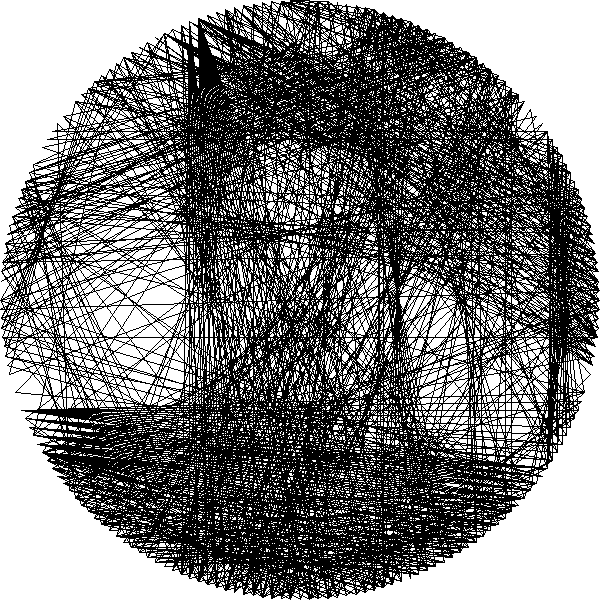

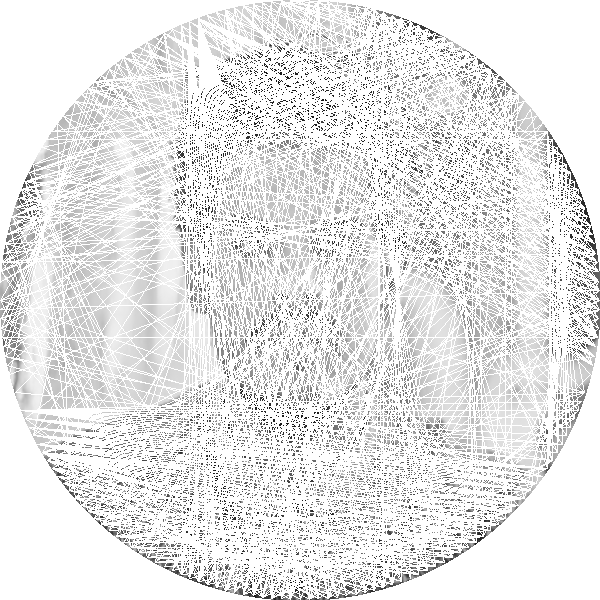

Current nail # 701 :  (123, 542)
Current nail # 702 :  (0, 290)
Current nail # 703 :  (139, 47)
Current nail # 704 :  (505, 81)
Current nail # 705 :  (225, 590)
Current nail # 706 :  (234, 7)
Current nail # 707 :  (594, 243)
Current nail # 708 :  (101, 75)
Current nail # 709 :  (57, 476)
Current nail # 710 :  (599, 290)
Current nail # 711 :  (29, 172)
Current nail # 712 :  (383, 12)
Current nail # 713 :  (435, 566)
Current nail # 714 :  (498, 75)
Current nail # 715 :  (309, 599)
Current nail # 716 :  (225, 9)
Current nail # 717 :  (337, 597)
Current nail # 718 :  (566, 435)
Current nail # 719 :  (12, 383)
Current nail # 720 :  (552, 139)
Current nail # 721 :  (5, 356)
Current nail # 722 :  (356, 5)
Current nail # 723 :  (518, 505)
Current nail # 724 :  (57, 123)
Current nail # 725 :  (271, 598)
Current nail # 726 :  (574, 181)
Current nail # 727 :  (42, 147)
Current nail # 728 :  (536, 483)
Current nail # 729 :  (15, 207)
Current nail # 730 :  (570, 427)
Current nail # 731 :  (253, 4)


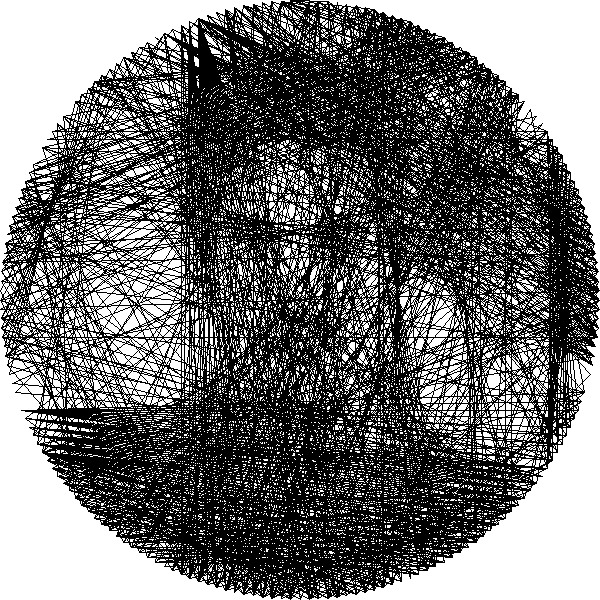

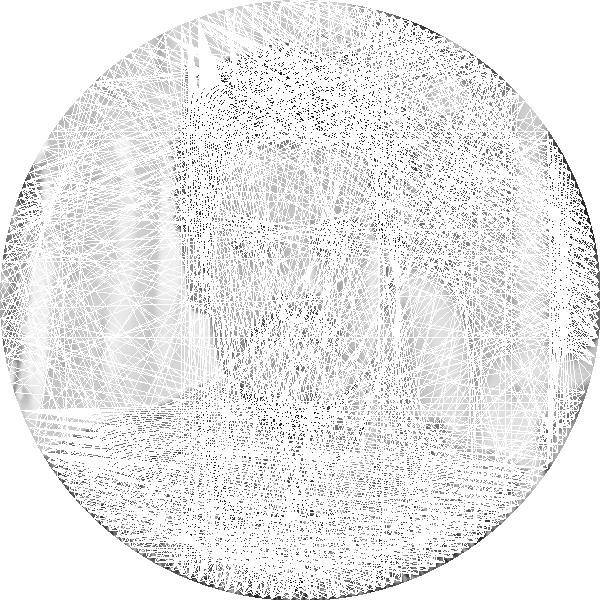

Current nail # 801 :  (581, 401)
Current nail # 802 :  (536, 116)
Current nail # 803 :  (57, 123)
Current nail # 804 :  (452, 42)
Current nail # 805 :  (109, 530)
Current nail # 806 :  (29, 172)
Current nail # 807 :  (542, 123)
Current nail # 808 :  (101, 524)
Current nail # 809 :  (590, 374)
Current nail # 810 :  (401, 581)
Current nail # 811 :  (116, 536)
Current nail # 812 :  (599, 300)
Current nail # 813 :  (1, 318)
Current nail # 814 :  (365, 592)
Current nail # 815 :  (392, 15)
Current nail # 816 :  (290, 0)
Current nail # 817 :  (356, 5)
Current nail # 818 :  (123, 542)
Current nail # 819 :  (511, 88)
Current nail # 820 :  (57, 476)
Current nail # 821 :  (123, 57)
Current nail # 822 :  (410, 578)
Current nail # 823 :  (75, 498)
Current nail # 824 :  (578, 189)
Current nail # 825 :  (281, 598)
Current nail # 826 :  (147, 42)
Current nail # 827 :  (524, 101)
Current nail # 828 :  (452, 557)
Current nail # 829 :  (401, 18)
Current nail # 830 :  (598, 271)
Current nail # 831 :  (5, 

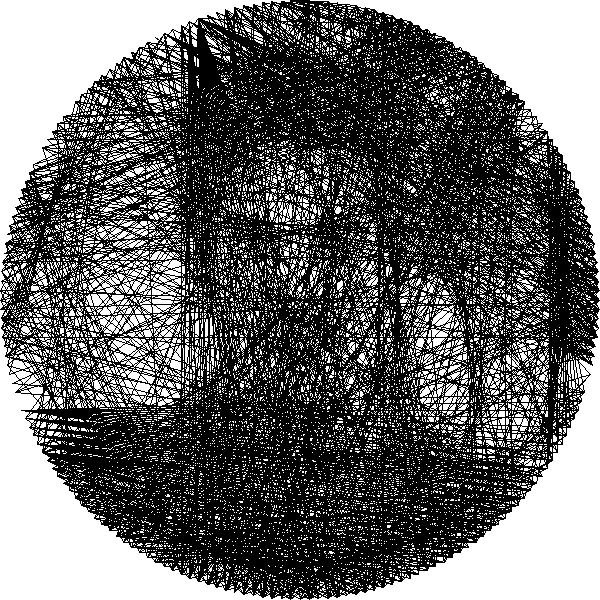

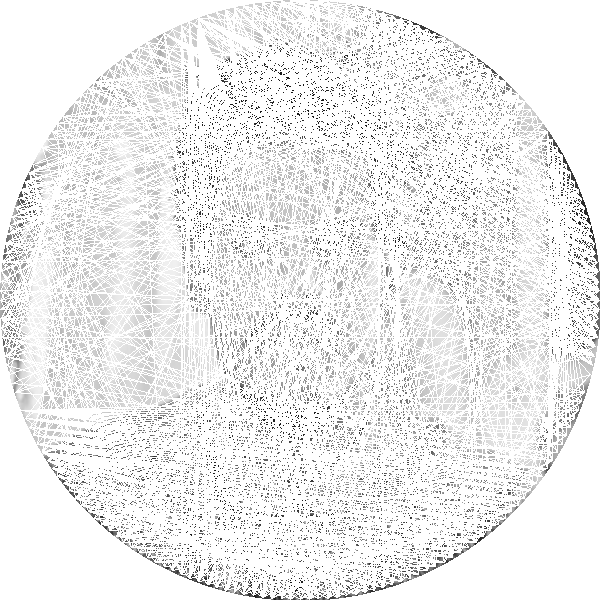

Current nail # 901 :  (383, 587)
Current nail # 902 :  (365, 7)
Current nail # 903 :  (300, 599)
Current nail # 904 :  (7, 234)
Current nail # 905 :  (94, 518)
Current nail # 906 :  (401, 18)
Current nail # 907 :  (47, 460)
Current nail # 908 :  (581, 198)
Current nail # 909 :  (346, 595)
Current nail # 910 :  (94, 81)
Current nail # 911 :  (365, 592)
Current nail # 912 :  (581, 401)
Current nail # 913 :  (0, 290)
Current nail # 914 :  (410, 21)
Current nail # 915 :  (21, 189)
Current nail # 916 :  (253, 595)
Current nail # 917 :  (15, 392)
Current nail # 918 :  (511, 88)
Current nail # 919 :  (1, 281)
Current nail # 920 :  (374, 590)
Current nail # 921 :  (547, 131)
Current nail # 922 :  (109, 69)
Current nail # 923 :  (427, 570)
Current nail # 924 :  (598, 318)
Current nail # 925 :  (37, 444)
Current nail # 926 :  (574, 181)
Current nail # 927 :  (139, 552)
Current nail # 928 :  (552, 460)
Current nail # 929 :  (234, 592)
Current nail # 930 :  (7, 234)
Current nail # 931 :  (570, 427

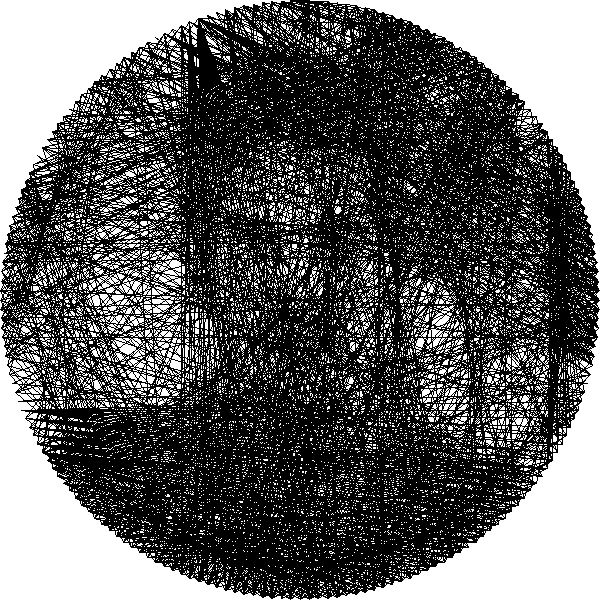

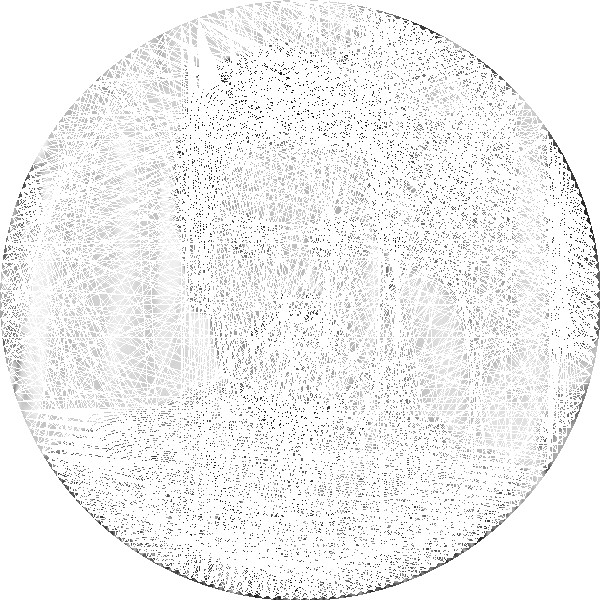

Current nail # 1001 :  (595, 253)
Current nail # 1002 :  (116, 536)
Current nail # 1003 :  (88, 88)
Current nail # 1004 :  (570, 172)
Current nail # 1005 :  (164, 33)
Current nail # 1006 :  (498, 75)
Current nail # 1007 :  (374, 590)
Current nail # 1008 :  (155, 37)
Current nail # 1009 :  (309, 599)
Current nail # 1010 :  (524, 101)
Current nail # 1011 :  (5, 356)
Current nail # 1012 :  (598, 271)
Current nail # 1013 :  (243, 594)
Current nail # 1014 :  (147, 42)
Current nail # 1015 :  (131, 547)
Current nail # 1016 :  (566, 435)
Current nail # 1017 :  (88, 511)
Current nail # 1018 :  (536, 116)
Current nail # 1019 :  (37, 444)
Current nail # 1020 :  (427, 29)
Current nail # 1021 :  (253, 4)
Current nail # 1022 :  (21, 189)
Current nail # 1023 :  (435, 566)
Current nail # 1024 :  (0, 290)
Current nail # 1025 :  (318, 598)
Current nail # 1026 :  (281, 1)
Current nail # 1027 :  (401, 18)
Current nail # 1028 :  (4, 346)
Current nail # 1029 :  (225, 590)
Current nail # 1030 :  (33, 164)
Cu

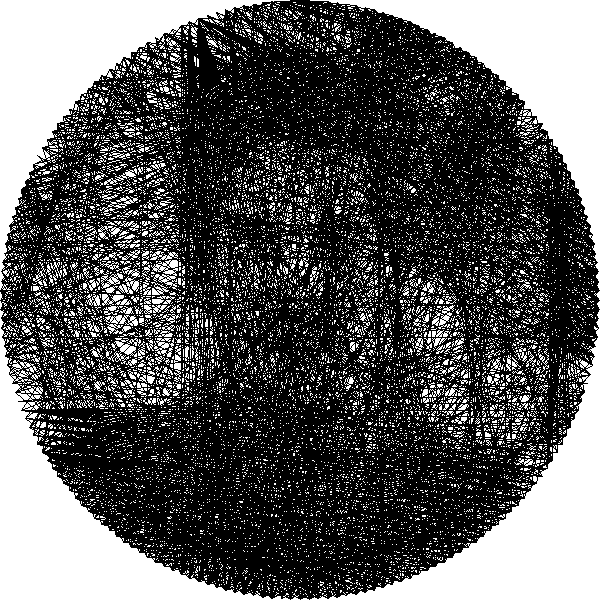

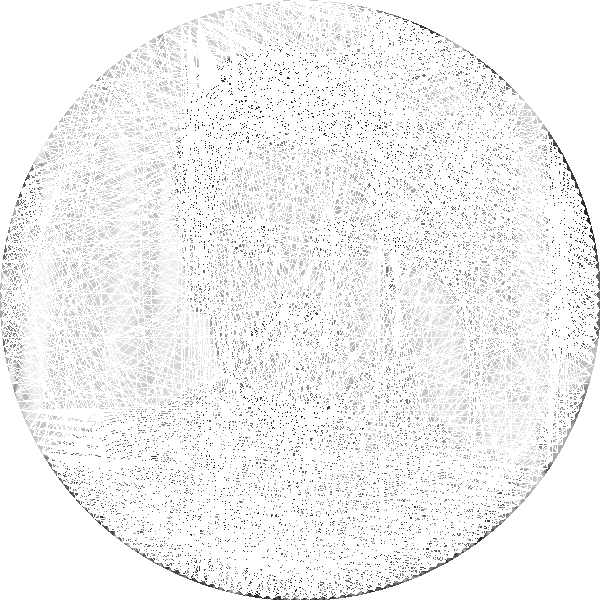

Current nail # 1101 :  (476, 542)
Current nail # 1102 :  (189, 578)
Current nail # 1103 :  (1, 318)
Current nail # 1104 :  (547, 468)
Current nail # 1105 :  (444, 37)
Current nail # 1106 :  (12, 383)
Current nail # 1107 :  (587, 216)
Current nail # 1108 :  (498, 524)
Current nail # 1109 :  (33, 164)
Current nail # 1110 :  (365, 592)
Current nail # 1111 :  (595, 253)
Current nail # 1112 :  (505, 518)
Current nail # 1113 :  (33, 435)
Current nail # 1114 :  (172, 29)
Current nail # 1115 :  (131, 547)
Current nail # 1116 :  (281, 1)
Current nail # 1117 :  (557, 147)
Current nail # 1118 :  (42, 452)
Current nail # 1119 :  (524, 101)
Current nail # 1120 :  (468, 547)
Current nail # 1121 :  (271, 1)
Current nail # 1122 :  (15, 207)
Current nail # 1123 :  (511, 511)
Current nail # 1124 :  (88, 88)
Current nail # 1125 :  (88, 511)
Current nail # 1126 :  (401, 18)
Current nail # 1127 :  (356, 594)
Current nail # 1128 :  (225, 9)
Current nail # 1129 :  (587, 383)
Current nail # 1130 :  (5, 356)
C

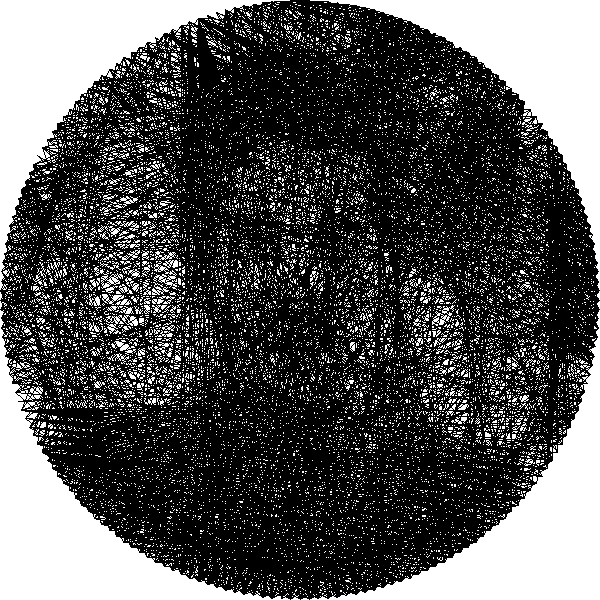

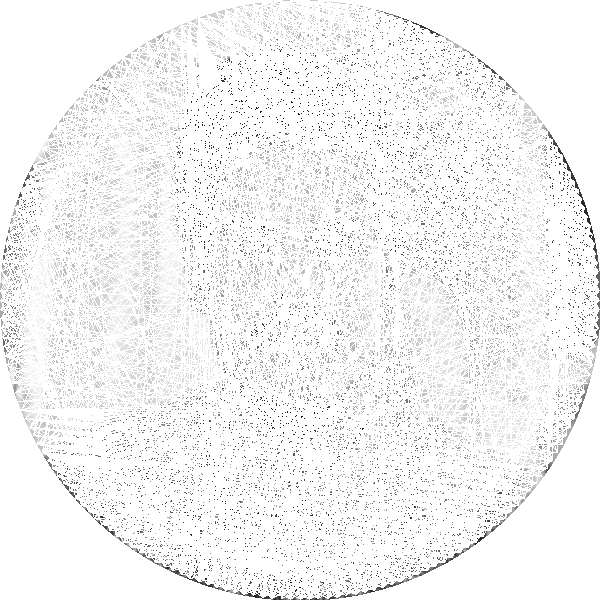

Current nail # 1201 :  (597, 337)
Current nail # 1202 :  (2, 262)
Current nail # 1203 :  (318, 1)
Current nail # 1204 :  (15, 392)
Current nail # 1205 :  (594, 356)
Current nail # 1206 :  (189, 578)
Current nail # 1207 :  (581, 198)
Current nail # 1208 :  (290, 0)
Current nail # 1209 :  (253, 595)
Current nail # 1210 :  (542, 476)
Current nail # 1211 :  (94, 81)
Current nail # 1212 :  (155, 562)
Current nail # 1213 :  (383, 12)
Current nail # 1214 :  (505, 518)
Current nail # 1215 :  (15, 207)
Current nail # 1216 :  (542, 476)
Current nail # 1217 :  (42, 452)
Current nail # 1218 :  (198, 18)
Current nail # 1219 :  (598, 318)
Current nail # 1220 :  (52, 131)
Current nail # 1221 :  (207, 584)
Current nail # 1222 :  (0, 309)
Current nail # 1223 :  (300, 599)
Current nail # 1224 :  (37, 155)
Current nail # 1225 :  (587, 383)
Current nail # 1226 :  (243, 5)
Current nail # 1227 :  (460, 47)
Current nail # 1228 :  (2, 337)
Current nail # 1229 :  (271, 598)
Current nail # 1230 :  (592, 234)
Cu

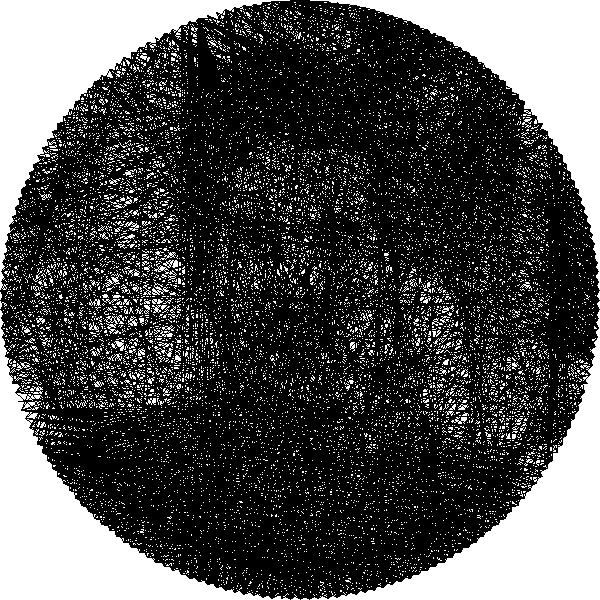

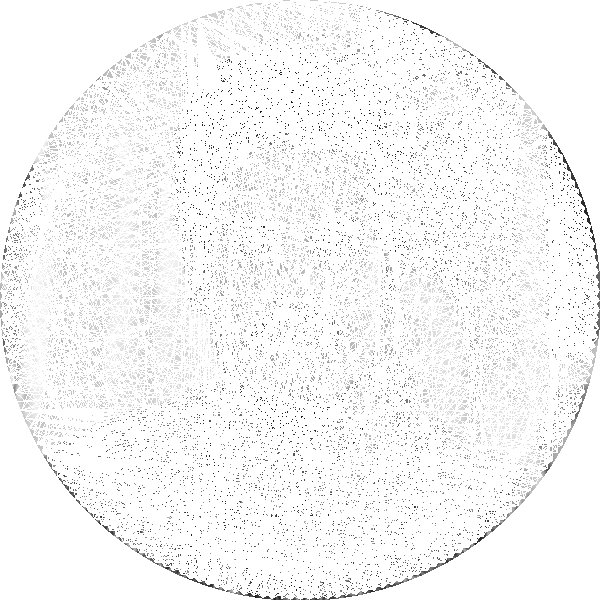

Current nail # 1301 :  (452, 42)
Current nail # 1302 :  (172, 570)
Current nail # 1303 :  (123, 57)
Current nail # 1304 :  (597, 337)
Current nail # 1305 :  (181, 25)
Current nail # 1306 :  (498, 524)
Current nail # 1307 :  (383, 12)
Current nail # 1308 :  (2, 337)
Current nail # 1309 :  (570, 172)
Current nail # 1310 :  (374, 590)
Current nail # 1311 :  (42, 147)
Current nail # 1312 :  (557, 452)
Current nail # 1313 :  (2, 262)
Current nail # 1314 :  (483, 63)
Current nail # 1315 :  (52, 468)
Current nail # 1316 :  (365, 7)
Current nail # 1317 :  (410, 578)
Current nail # 1318 :  (29, 172)
Current nail # 1319 :  (566, 164)
Current nail # 1320 :  (123, 57)
Current nail # 1321 :  (0, 309)
Current nail # 1322 :  (189, 21)
Current nail # 1323 :  (4, 253)
Current nail # 1324 :  (281, 598)
Current nail # 1325 :  (476, 57)
Current nail # 1326 :  (234, 7)
Current nail # 1327 :  (547, 468)
Current nail # 1328 :  (18, 401)
Current nail # 1329 :  (584, 392)
Current nail # 1330 :  (1, 271)
Curren

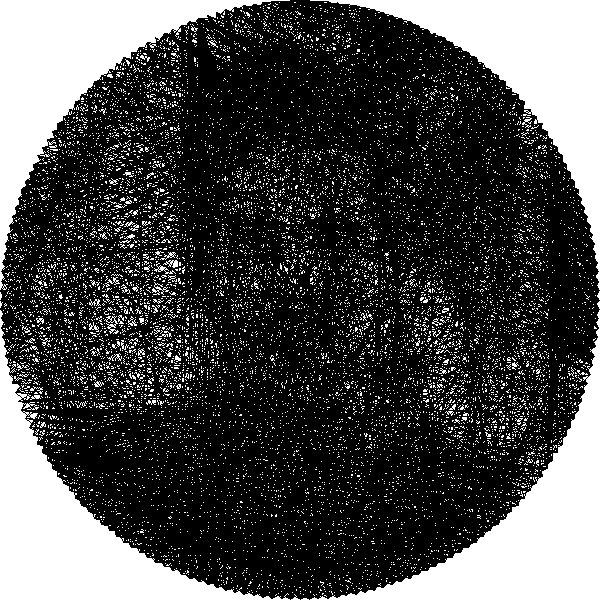

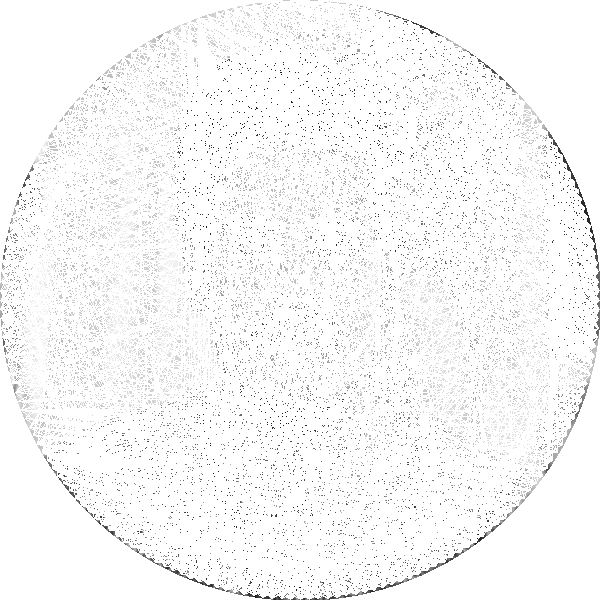

Current nail # 1401 :  (109, 69)
Current nail # 1402 :  (328, 1)
Current nail # 1403 :  (578, 189)
Current nail # 1404 :  (383, 587)
Current nail # 1405 :  (2, 337)
Current nail # 1406 :  (570, 427)
Current nail # 1407 :  (243, 594)
Current nail # 1408 :  (18, 401)
Current nail # 1409 :  (590, 225)
Current nail # 1410 :  (309, 599)
Current nail # 1411 :  (5, 243)
Current nail # 1412 :  (562, 444)
Current nail # 1413 :  (123, 57)
Current nail # 1414 :  (598, 318)
Current nail # 1415 :  (1, 328)
Current nail # 1416 :  (581, 198)
Current nail # 1417 :  (15, 207)
Current nail # 1418 :  (476, 57)
Current nail # 1419 :  (198, 581)
Current nail # 1420 :  (172, 29)
Current nail # 1421 :  (566, 435)
Current nail # 1422 :  (5, 356)
Current nail # 1423 :  (505, 518)
Current nail # 1424 :  (81, 94)
Current nail # 1425 :  (356, 594)
Current nail # 1426 :  (337, 2)
Current nail # 1427 :  (530, 490)
Current nail # 1428 :  (483, 63)
Current nail # 1429 :  (116, 536)
Current nail # 1430 :  (109, 69)
Cu

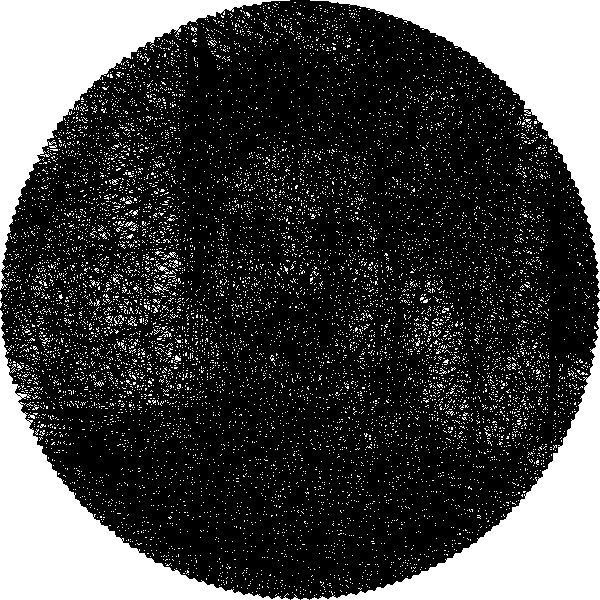

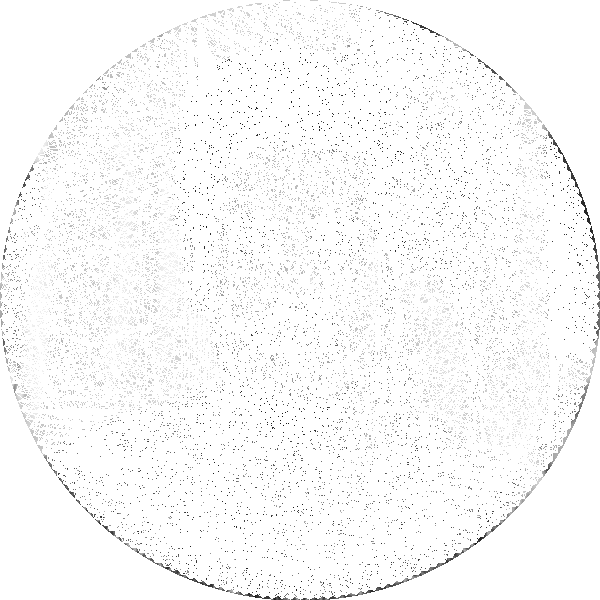

Current nail # 1501 :  (207, 15)
Current nail # 1502 :  (587, 216)
Current nail # 1503 :  (123, 542)
Current nail # 1504 :  (52, 131)
Current nail # 1505 :  (383, 587)
Current nail # 1506 :  (234, 7)
Current nail # 1507 :  (562, 155)
Current nail # 1508 :  (1, 281)
Current nail # 1509 :  (518, 505)
Current nail # 1510 :  (243, 5)
Current nail # 1511 :  (309, 0)
Current nail # 1512 :  (216, 12)
Current nail # 1513 :  (511, 88)
Current nail # 1514 :  (9, 374)
Current nail # 1515 :  (262, 597)
Current nail # 1516 :  (29, 172)
Current nail # 1517 :  (300, 0)
Current nail # 1518 :  (557, 452)
Current nail # 1519 :  (290, 599)
Current nail # 1520 :  (75, 101)
Current nail # 1521 :  (598, 328)
Current nail # 1522 :  (33, 164)
Current nail # 1523 :  (599, 300)
Current nail # 1524 :  (81, 505)
Current nail # 1525 :  (581, 401)
Current nail # 1526 :  (109, 69)
Current nail # 1527 :  (42, 452)
Current nail # 1528 :  (498, 75)
Current nail # 1529 :  (21, 189)
Current nail # 1530 :  (172, 570)
Curr

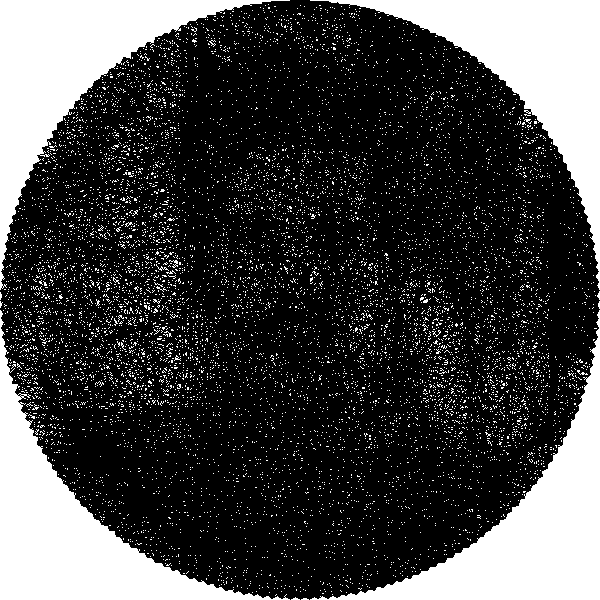

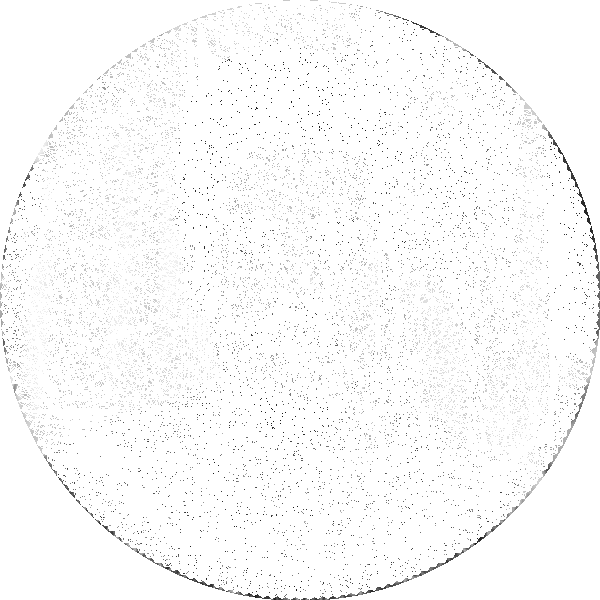

Current nail # 1601 :  (18, 401)
Current nail # 1602 :  (401, 18)
Current nail # 1603 :  (33, 435)
Current nail # 1604 :  (262, 597)
Current nail # 1605 :  (5, 356)
Current nail # 1606 :  (181, 25)
Current nail # 1607 :  (37, 444)
Current nail # 1608 :  (557, 452)
Current nail # 1609 :  (18, 198)
Current nail # 1610 :  (75, 498)
Current nail # 1611 :  (52, 131)
Current nail # 1612 :  (594, 356)
Current nail # 1613 :  (243, 5)
Current nail # 1614 :  (444, 37)
Current nail # 1615 :  (101, 75)
Current nail # 1616 :  (181, 574)
Current nail # 1617 :  (581, 401)
Current nail # 1618 :  (498, 75)
Current nail # 1619 :  (365, 592)
Current nail # 1620 :  (116, 63)
Current nail # 1621 :  (4, 346)
Current nail # 1622 :  (584, 392)
Current nail # 1623 :  (69, 490)
Current nail # 1624 :  (505, 81)
Current nail # 1625 :  (21, 410)
Current nail # 1626 :  (587, 383)
Current nail # 1627 :  (524, 101)
Current nail # 1628 :  (29, 427)
Current nail # 1629 :  (594, 356)
Current nail # 1630 :  (225, 9)
Curr

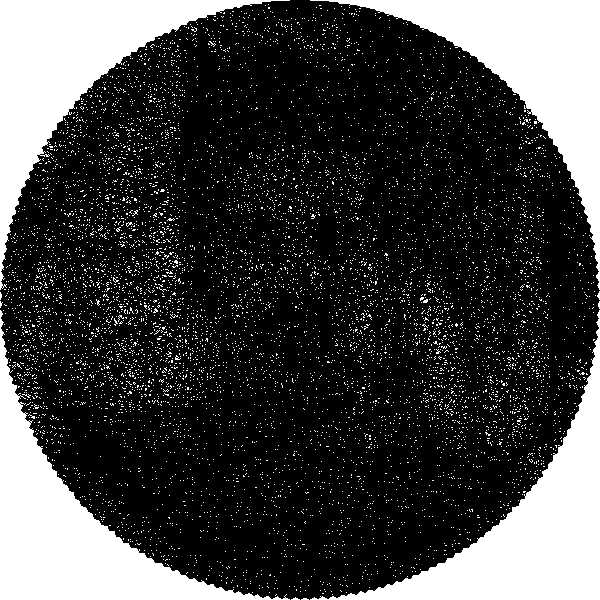

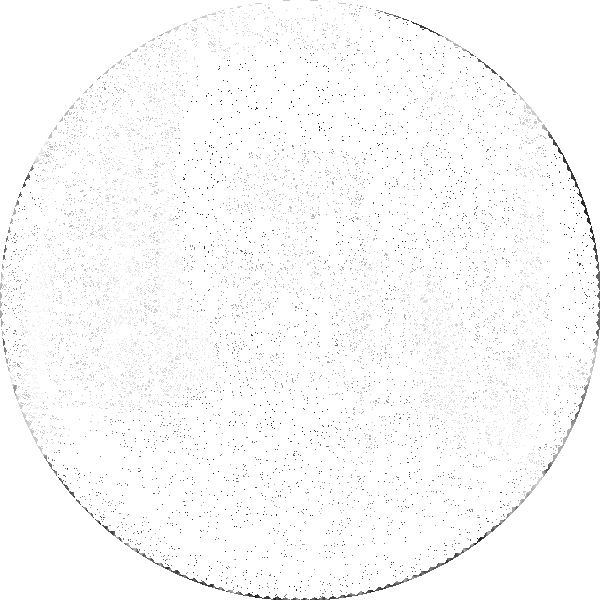

Current nail # 1701 :  (0, 309)
Current nail # 1702 :  (498, 75)
Current nail # 1703 :  (9, 374)
Current nail # 1704 :  (574, 418)
Current nail # 1705 :  (131, 52)
Current nail # 1706 :  (374, 9)
Current nail # 1707 :  (599, 290)
Current nail # 1708 :  (9, 225)
Current nail # 1709 :  (271, 598)
Current nail # 1710 :  (12, 383)
Current nail # 1711 :  (599, 300)
Current nail # 1712 :  (318, 598)
Current nail # 1713 :  (427, 29)
Current nail # 1714 :  (172, 29)
Current nail # 1715 :  (172, 570)
Current nail # 1716 :  (4, 346)
Current nail # 1717 :  (518, 94)
Current nail # 1718 :  (542, 476)
Current nail # 1719 :  (410, 21)
Current nail # 1720 :  (47, 139)
Current nail # 1721 :  (401, 581)
Current nail # 1722 :  (5, 243)
Current nail # 1723 :  (198, 581)
Current nail # 1724 :  (557, 452)
Current nail # 1725 :  (116, 63)
Current nail # 1726 :  (574, 181)
Current nail # 1727 :  (365, 592)
Current nail # 1728 :  (75, 498)
Current nail # 1729 :  (452, 42)
Current nail # 1730 :  (101, 524)
Cur

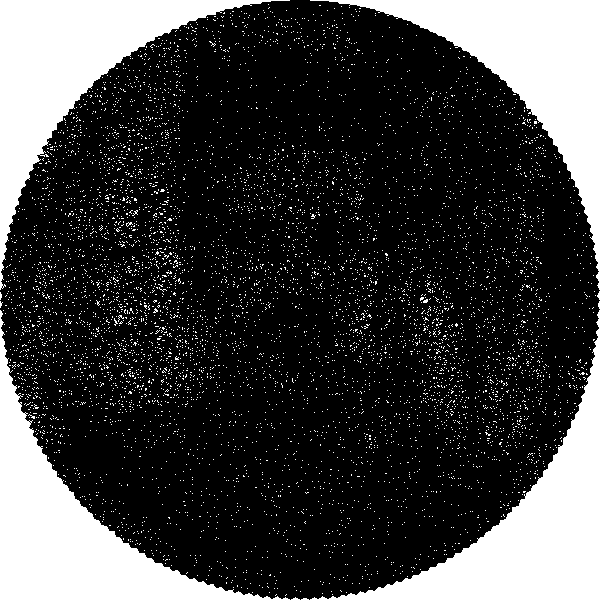

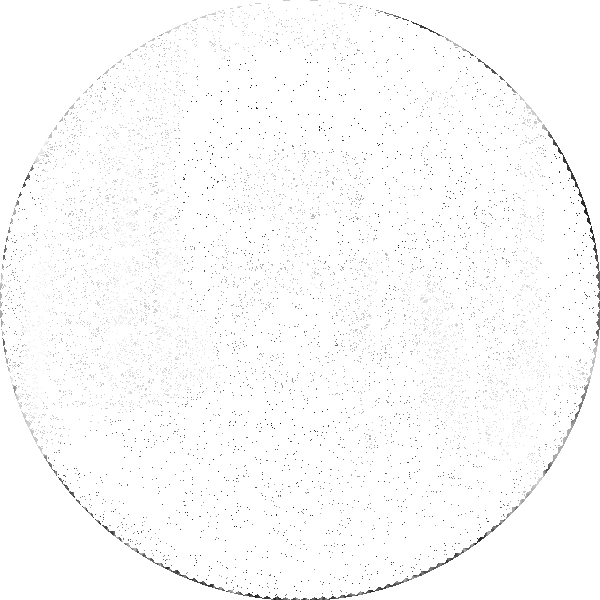

Current nail # 1801 :  (598, 318)
Current nail # 1802 :  (94, 518)
Current nail # 1803 :  (164, 33)
Current nail # 1804 :  (383, 587)
Current nail # 1805 :  (21, 189)
Current nail # 1806 :  (599, 300)
Current nail # 1807 :  (75, 101)
Current nail # 1808 :  (63, 483)
Current nail # 1809 :  (42, 147)
Current nail # 1810 :  (599, 309)
Current nail # 1811 :  (155, 562)
Current nail # 1812 :  (518, 505)
Current nail # 1813 :  (2, 262)
Current nail # 1814 :  (281, 598)
Current nail # 1815 :  (574, 181)
Current nail # 1816 :  (9, 225)
Current nail # 1817 :  (88, 511)
Current nail # 1818 :  (581, 198)
Current nail # 1819 :  (172, 570)
Current nail # 1820 :  (452, 557)
Current nail # 1821 :  (12, 383)
Current nail # 1822 :  (518, 94)
Current nail # 1823 :  (300, 599)
Current nail # 1824 :  (337, 2)
Current nail # 1825 :  (164, 566)
Current nail # 1826 :  (356, 5)
Current nail # 1827 :  (595, 346)
Current nail # 1828 :  (147, 42)
Current nail # 1829 :  (562, 155)
Current nail # 1830 :  (94, 81)


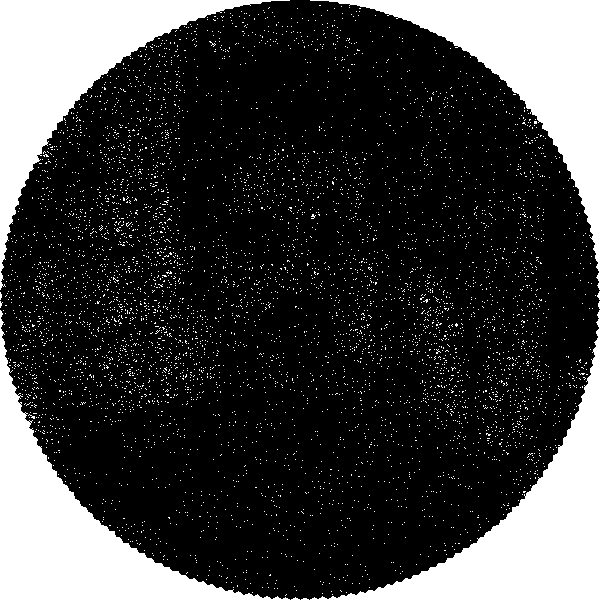

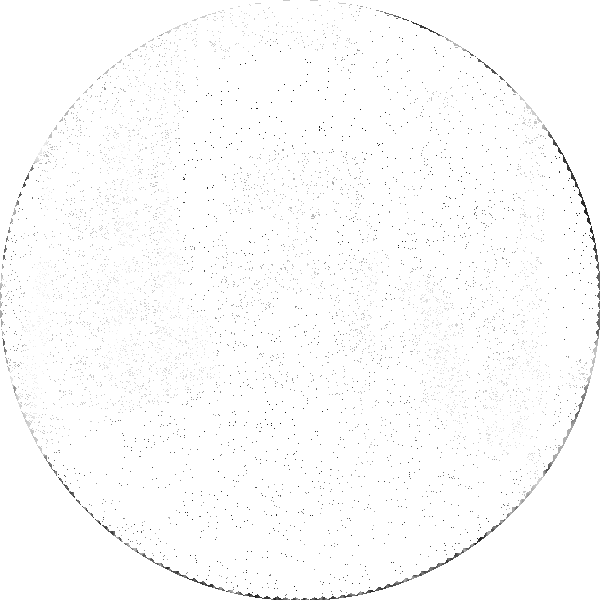

Current nail # 1901 :  (15, 392)
Current nail # 1902 :  (63, 116)
Current nail # 1903 :  (309, 599)
Current nail # 1904 :  (562, 155)
Current nail # 1905 :  (155, 37)
Current nail # 1906 :  (584, 392)
Current nail # 1907 :  (7, 365)
Current nail # 1908 :  (383, 587)
Current nail # 1909 :  (109, 530)
Current nail # 1910 :  (410, 21)
Current nail # 1911 :  (290, 0)
Current nail # 1912 :  (5, 243)
Current nail # 1913 :  (300, 599)
Current nail # 1914 :  (418, 25)
Current nail # 1915 :  (597, 262)
Current nail # 1916 :  (181, 25)
Current nail # 1917 :  (139, 552)
Current nail # 1918 :  (592, 365)
Current nail # 1919 :  (33, 164)
Current nail # 1920 :  (281, 1)
Current nail # 1921 :  (1, 328)
Current nail # 1922 :  (181, 25)
Current nail # 1923 :  (7, 365)
Current nail # 1924 :  (530, 109)
Current nail # 1925 :  (164, 566)
Current nail # 1926 :  (123, 57)
Current nail # 1927 :  (52, 468)
Current nail # 1928 :  (164, 33)
Current nail # 1929 :  (542, 476)
Current nail # 1930 :  (524, 101)
Cur

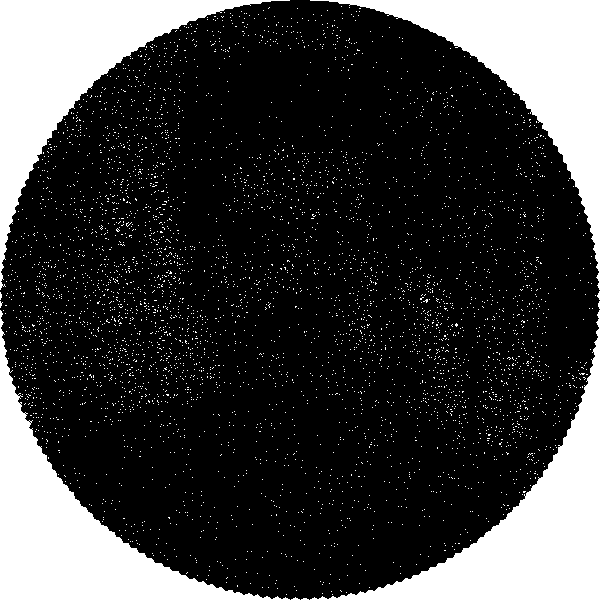

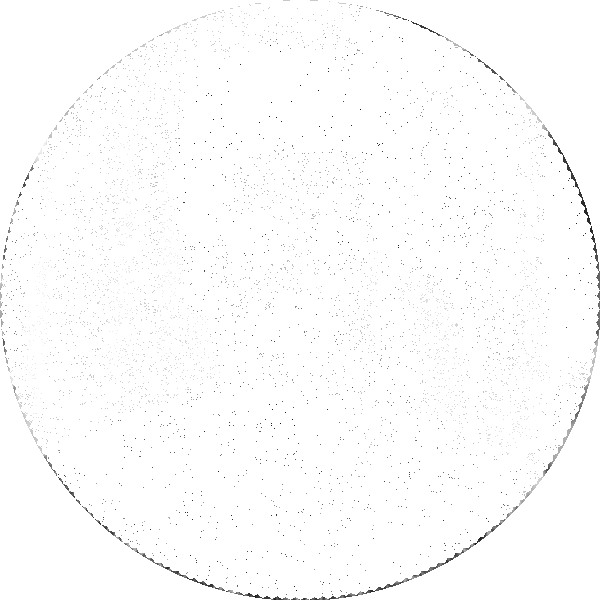

Current nail # 2001 :  (52, 131)
Current nail # 2002 :  (592, 234)
Current nail # 2003 :  (498, 524)
Current nail # 2004 :  (37, 155)
Current nail # 2005 :  (281, 1)
Current nail # 2006 :  (374, 9)
Current nail # 2007 :  (37, 444)
Current nail # 2008 :  (476, 57)
Current nail # 2009 :  (392, 584)
Current nail # 2010 :  (29, 172)
Current nail # 2011 :  (598, 281)
Current nail # 2012 :  (1, 318)
Current nail # 2013 :  (234, 592)
Current nail # 2014 :  (365, 7)
Current nail # 2015 :  (1, 271)
Current nail # 2016 :  (498, 524)
Current nail # 2017 :  (75, 498)
Current nail # 2018 :  (557, 147)
Current nail # 2019 :  (300, 599)
Current nail # 2020 :  (116, 63)
Current nail # 2021 :  (318, 1)
Current nail # 2022 :  (198, 18)
Current nail # 2023 :  (401, 18)
Current nail # 2024 :  (0, 309)
Current nail # 2025 :  (181, 574)
Current nail # 2026 :  (566, 435)
Current nail # 2027 :  (365, 7)
Current nail # 2028 :  (47, 139)
Current nail # 2029 :  (595, 253)
Current nail # 2030 :  (9, 225)
Current 

KeyboardInterrupt: 

In [7]:

# Start at random nail 
# Get all unused threds from that nail
# Put through fitness function
# Select best thread
# Add to used threads
# Go to next nail
# Repeat until fitness function returns positive values
# If no positive values, undo last nail and choose second best thread (parametrize how many step to go back)
# Repeat until no improvement can be made

# Save image

input_image = get_input_image()
output_image = generate_new_image(OUTPUT_IMAGE_DIMENSIONS)
nails = generate_nail_positions(OUTPUT_IMAGE_RADIUS, OUTPUT_IMAGE_CENTER_POSITION, NAILS_AMOUNT)
threads = generate_thread_positions(nails)
# display(nails)
# display(nails[0])

# display(input_image)
# display(threads)
# display(threads[0])
# display_points(nails, output_image)

ntt = generate_nail_to_threads_dictionary(nails, threads)
ttp = generate_thread_to_points_dictionary(threads)
# display_threads(ntt[nails[0]], output_image)

# display(ntt)
# display(ntt[nails[0]])

# display(ttp[threads[0]])

used_threads = []
current_nail = nails[0]
current_input_image = input_image.copy()
for i in range(0, 4000):

    print("Current nail #", i, ": ", str(current_nail))
    if i % 100 == 0:
        display_threads(used_threads, output_image)
        display(current_input_image)
    # Make dictionary nail to threads
    current_threads = ntt[current_nail]

    # print("Current threads: ", str(current_threads))
    
    selected_thread = get_best_fitting_thread(current_threads, ttp, current_input_image)
    # selected_thread = current_threads[np.random.randint(0, len(current_threads))]

    used_threads.append(selected_thread)
    ntt[current_nail].remove(selected_thread)
    ntt[get_other_end_of_thread(selected_thread, current_nail)].remove(selected_thread)

    if len(ntt[current_nail]) == 1: # If only one thread left, nail is done
        for thread in ntt[current_nail]:
            ntt[current_nail].remove(thread)
            ntt[get_other_end_of_thread(thread, current_nail)].remove(thread)


    # ntt[current_nail] = [thread for thread in current_threads if thread != selected_thread]
    # ttp[selected_thread] = []
    # threads.remove(selected_thread)

    current_input_image = draw_line(current_input_image, selected_thread)

    # display(current_input_image)
    # display(display_threads(used_threads, output_image))

    current_nail = get_other_end_of_thread(selected_thread, current_nail)

current_input_image.save('nails.png')
display_threads(used_threads, output_image)
